Importamos el dataset de sporulacion filtrado

In [21]:
import pandas as pd

# Carga el archivo tabulado como DataFrame
df = pd.read_csv('sporulation-filtered.txt', sep='\t',decimal=',')

#quitamos mean y variacion
df = df[0:-2]
y = df['Genes']
x = df.drop('Genes',axis=1)

# Mostrar las primeras filas del DataFrame
print(x)
print(y)

           t0      t0,5        t2        t5        t7        t9     t11,5
0    1.163781 -1.758143 -0.314950  0.283874 -0.677900  0.470183  0.833156
1    0.955552 -1.489560 -0.499057 -0.099143 -0.674453  1.414381  0.392280
2    1.454598 -0.735149 -0.073602 -0.618896 -0.789697  1.391507 -0.628760
3    1.698578 -1.268638 -0.375511  0.996817 -0.319158 -0.344837 -0.387251
4    1.302831 -1.338633 -0.555163 -0.101402 -0.674167  1.317301  0.049233
..        ...       ...       ...       ...       ...       ...       ...
469  1.473570 -0.980588  0.187547 -0.775976 -1.067287  0.126038  1.036696
470  1.543327 -1.090000 -0.374713 -0.780946 -0.671057  0.308319  1.065071
471  1.855230 -0.550056 -0.264951 -1.042622 -0.729874 -0.019525  0.751798
472  1.785611 -0.406223 -0.895333 -0.585125 -0.816870  0.003997  0.913943
473  1.552631 -0.019515 -0.392120 -1.218152 -0.896972 -0.092712  1.066840

[474 rows x 7 columns]
0      YAL025C
1      YAL036C
2      YAL040C
3      YDL037c
4      YDR184C
        ...  

Normalizacion

In [31]:
import pandas as pd

# Supongamos que ya has cargado tu DataFrame y que `x` es tu matriz de expresión
# Normalizar usando Z-score
x_normalized = (x - x.mean(axis=1).values[:, None]) / x.std(axis=1).values[:, None]

# Mostrar las primeras filas del DataFrame normalizado
print(x_normalized.head())

# Si necesitas concatenar los nombres de los genes de nuevo, puedes hacerlo así:
df = pd.DataFrame(x_normalized, columns=x.columns)
df['Genes'] = y.values  # Añadir la columna de genes

# Mostrar el DataFrame normalizado
print(df.head())


         t0      t0,5        t2        t5        t7        t9     t11,5
0  1.163781 -1.758143 -0.314950  0.283874 -0.677900  0.470183  0.833156
1  0.955552 -1.489560 -0.499057 -0.099143 -0.674453  1.414381  0.392280
2  1.454598 -0.735149 -0.073602 -0.618896 -0.789697  1.391507 -0.628760
3  1.698578 -1.268638 -0.375511  0.996817 -0.319158 -0.344837 -0.387251
4  1.302831 -1.338633 -0.555163 -0.101402 -0.674167  1.317301  0.049233
         t0      t0,5        t2        t5        t7        t9     t11,5  \
0  1.163781 -1.758143 -0.314950  0.283874 -0.677900  0.470183  0.833156   
1  0.955552 -1.489560 -0.499057 -0.099143 -0.674453  1.414381  0.392280   
2  1.454598 -0.735149 -0.073602 -0.618896 -0.789697  1.391507 -0.628760   
3  1.698578 -1.268638 -0.375511  0.996817 -0.319158 -0.344837 -0.387251   
4  1.302831 -1.338633 -0.555163 -0.101402 -0.674167  1.317301  0.049233   

     Genes  
0  YAL025C  
1  YAL036C  
2  YAL040C  
3  YDL037c  
4  YDR184C  


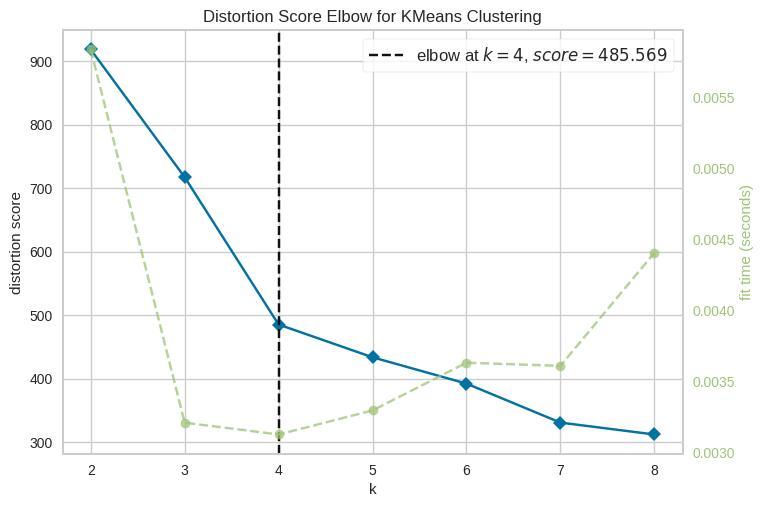

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,9)) # a range of k values from 2 to 9

visualizer.fit(x)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

creo que concuerda con los papers por lo de temprano medio largo y medio temprano

<ipython-input-33-ba1e65ebcd5c>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_pca[:, 0], x_pca[:, 1], cmap=plt.cm.Set1, edgecolor="k")


Text(0, 0.5, 'Second principal component')

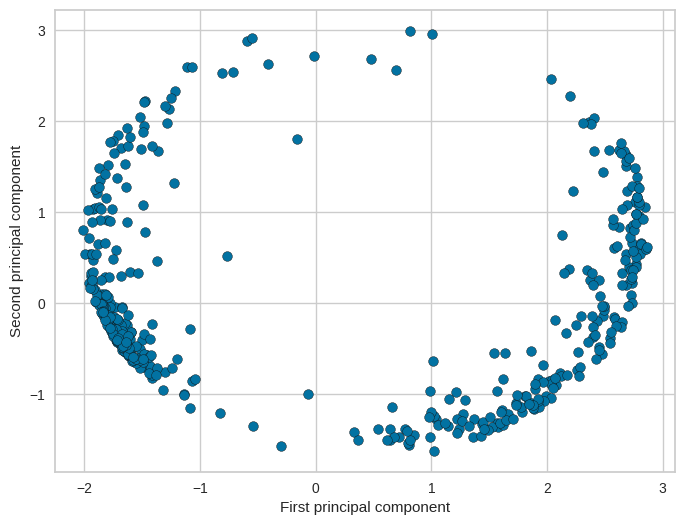

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)


plt.figure(2, figsize=(8, 6))
plt.clf()
plt.scatter(x_pca[:, 0], x_pca[:, 1], cmap=plt.cm.Set1, edgecolor="k")
# plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")

plt.xlabel("First principal component")
plt.ylabel("Second principal component")

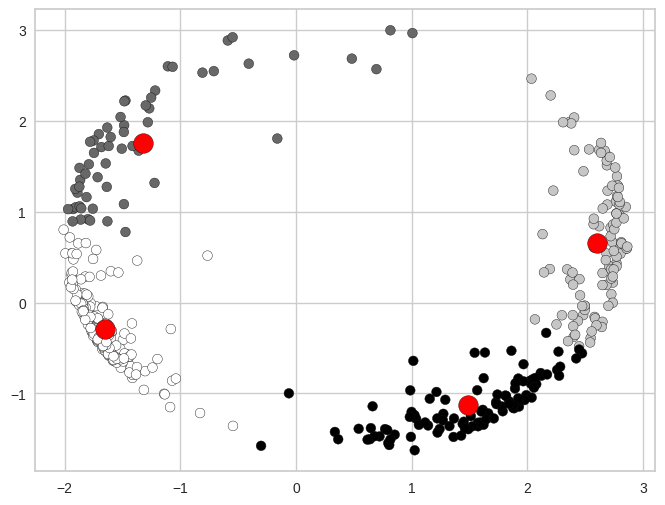

In [34]:
clusterer = KMeans(n_clusters=4)
cluster_labels = clusterer.fit_predict(x_pca)
# show the actual clusters formed and centroids
plt.figure(2, figsize=(8, 6))
plt.clf()
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=clusterer.labels_, edgecolor="k")
# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw red circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker="o", c="red", s=200, edgecolor="k")

In [35]:
cluster_labels = clusterer.fit_predict(x)
df['cluster'] = cluster_labels
print(df)

           t0      t0,5        t2        t5        t7        t9     t11,5  \
0    1.163781 -1.758143 -0.314950  0.283874 -0.677900  0.470183  0.833156   
1    0.955552 -1.489560 -0.499057 -0.099143 -0.674453  1.414381  0.392280   
2    1.454598 -0.735149 -0.073602 -0.618896 -0.789697  1.391507 -0.628760   
3    1.698578 -1.268638 -0.375511  0.996817 -0.319158 -0.344837 -0.387251   
4    1.302831 -1.338633 -0.555163 -0.101402 -0.674167  1.317301  0.049233   
..        ...       ...       ...       ...       ...       ...       ...   
469  1.473570 -0.980588  0.187547 -0.775976 -1.067287  0.126038  1.036696   
470  1.543327 -1.090000 -0.374713 -0.780946 -0.671057  0.308319  1.065071   
471  1.855230 -0.550056 -0.264951 -1.042622 -0.729874 -0.019525  0.751798   
472  1.785611 -0.406223 -0.895333 -0.585125 -0.816870  0.003997  0.913943   
473  1.552631 -0.019515 -0.392120 -1.218152 -0.896972 -0.092712  1.066840   

       Genes  cluster  
0    YAL025C        3  
1    YAL036C        3  
2  

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

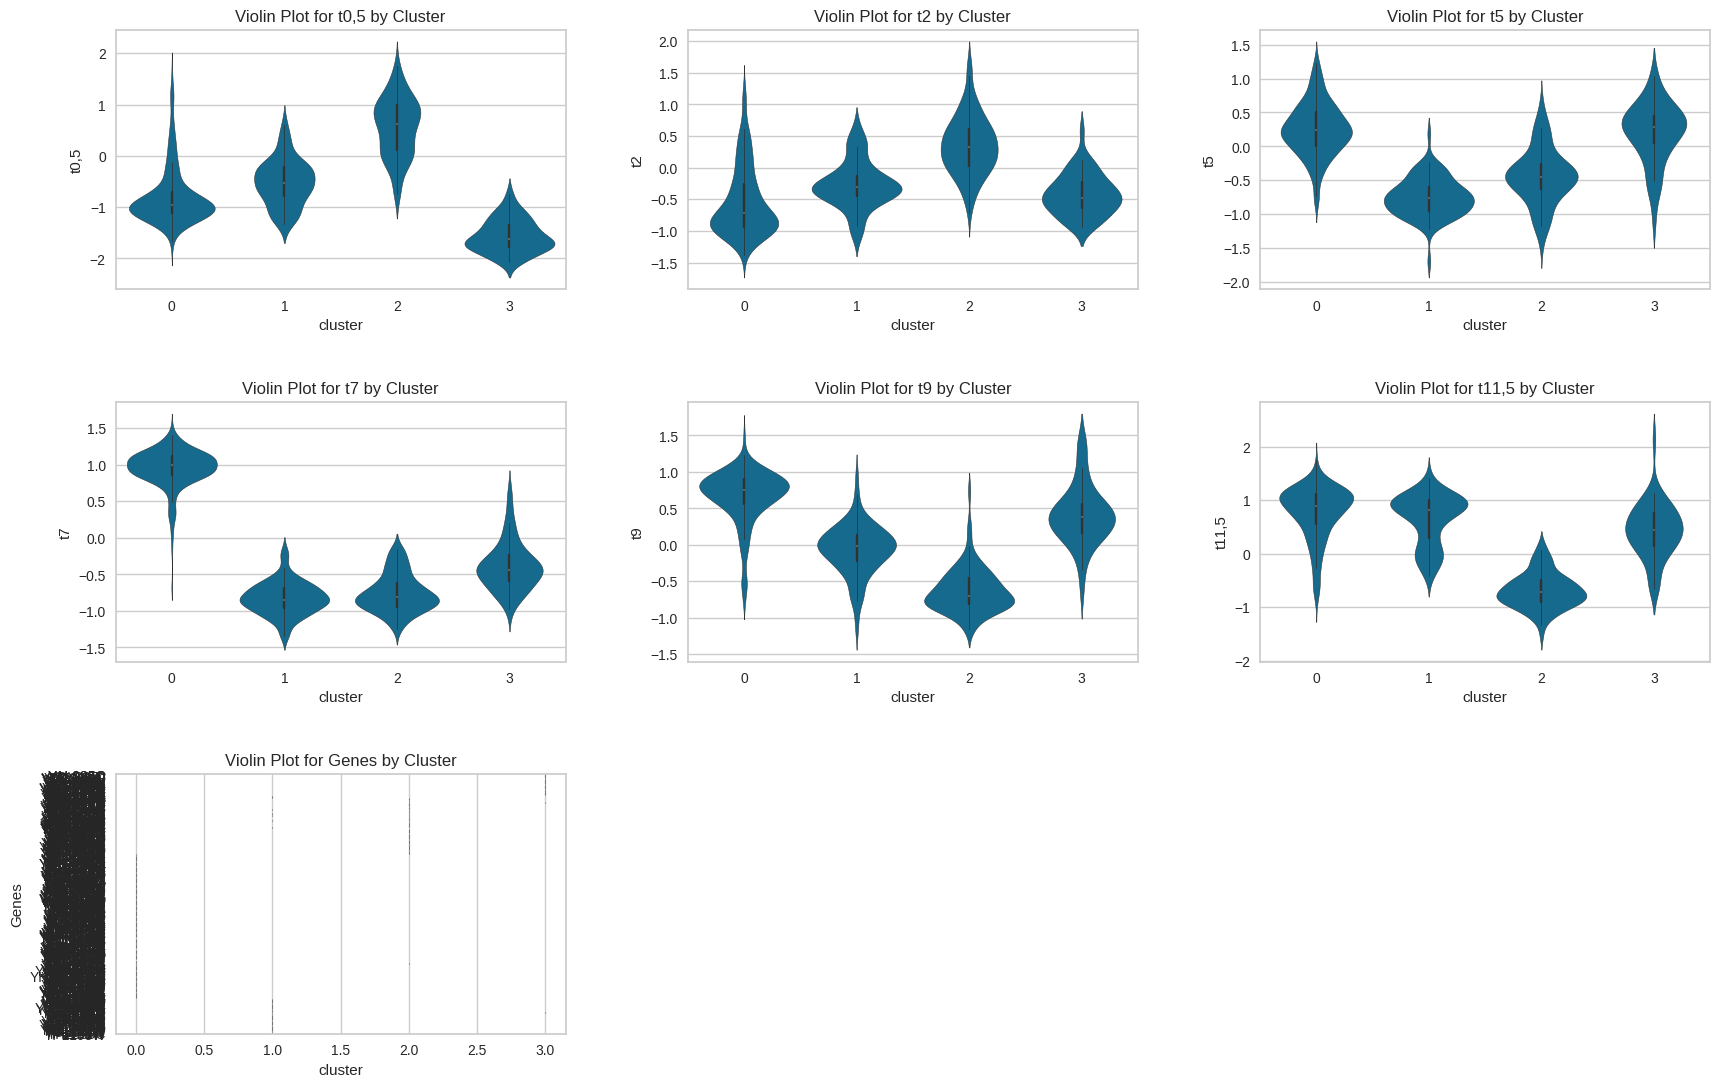

In [36]:
import math
# Número de variables a graficar
num_vars = len(df.columns[1:-1])

# Calcular filas y columnas para los subplots
cols = 3  # Número de gráficos por fila
rows = math.ceil(num_vars / cols)  # Número de filas necesarias

# Crear subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
fig.tight_layout(pad=5.0)  # Espaciado entre gráficos

# Iterar sobre las variables y graficarlas
for i, var in enumerate(df.columns[0:-1]):
    row = i // cols
    col = i % cols
    sns.violinplot(x=df['cluster'], y=var, data=df, ax=axes[row, col])
    axes[row, col].set_title(f'Violin Plot for {var} by Cluster')

# Eliminar ejes vacíos si hay
for i in range(num_vars, rows * cols):
    fig.delaxes(axes.flat[i])

plt.show()

VAMOS A CAMBIAR LAS K Y PROBAR PARA CADA K UNA METRICA DE VALIDACION DIFERENTE de los papers

en el paper 2 usa (I) The average proportion of non-overlap measure
(II) The average distance between means measure
(III) The average distance measure

In [43]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

# Crear un DataFrame para almacenar los resultados
results = pd.DataFrame(columns=['Method', 'k', 'Silhouette Score', 'Mean Distance to Centroids', 'Average Distance Between Clusters', 'Non-Overlap Measure'])

# Función para calcular la medida de no solapamiento
def non_overlap_measure(labels):
    unique_labels = np.unique(labels)
    overlap = 0
    for label in unique_labels:
        cluster_points = labels == label
        overlap += np.sum(cluster_points) ** 2
    return overlap

# Lista de métodos de clustering
methods = {
    'KMeans': KMeans,
    'Agglomerative': AgglomerativeClustering,
    'Gaussian Mixture': GaussianMixture
}

# Lista para almacenar los resultados
results_list = []

# Iterar sobre diferentes métodos y valores de k
for method_name, method in methods.items():
    for k in range(2, 15):  # Iniciar en 2 para que el Silhouette tenga sentido
        if method_name == 'KMeans':
            clusterer = method(n_clusters=k, random_state=42)
            cluster_labels = clusterer.fit_predict(x)
            centroids = clusterer.cluster_centers_
        elif method_name == 'Agglomerative':
            clusterer = method(n_clusters=k)
            cluster_labels = clusterer.fit_predict(x)
            centroids = None  # Agglomerative no tiene centroids
        elif method_name == 'Gaussian Mixture':
            clusterer = method(n_components=k, random_state=42)
            cluster_labels = clusterer.fit_predict(x)
            centroids = clusterer.means_

        # Silhouette Score
        silhouette_avg = silhouette_score(x, cluster_labels)

        # Mean Distance to Centroids (solo para métodos con centros)
        if centroids is not None:
            mean_distance = np.mean(np.min(cdist(x, centroids), axis=1))
        else:
            mean_distance = np.nan

        # Average Distance Between Clusters
        avg_distance = 0
        for i in range(k):
            for j in range(i + 1, k):
                avg_distance += np.mean(cdist(x[cluster_labels == i], x[cluster_labels == j]))
        avg_distance /= (k * (k - 1)) / 2  # Promedio total

        # Non-Overlap Measure
        non_overlap = non_overlap_measure(cluster_labels)

        # Almacenar resultados en una lista
        results_list.append({
            'Method': method_name,
            'k': k,
            'Silhouette Score': silhouette_avg,
            'Mean Distance to Centroids': mean_distance,
            'Average Distance Between Clusters': avg_distance,
            'Non-Overlap Measure': non_overlap
        })

# Convertir la lista de resultados a un DataFrame
results = pd.DataFrame(results_list)

# Estilizar la tabla
styled_results = results.style \
    .set_table_attributes('style="width:100%; border-collapse:collapse;"') \
    .set_properties(**{'border': '1px solid black', 'text-align': 'center'}) \
    .background_gradient(cmap='viridis', subset=['Silhouette Score', 'Mean Distance to Centroids', 'Average Distance Between Clusters', 'Non-Overlap Measure']) \
    .highlight_max(color='lightgreen', axis=0, props='text-decoration: underline;') \
    .highlight_min(color='salmon', axis=0) \
    .set_caption("Resultados de Clustering con Distintos Métodos") \
    .set_table_attributes('style="border: 2px solid black; border-collapse: collapse; font-size: 12px; margin: 20px 0;"')

# Guardar la tabla estilizada en HTML
html_table = styled_results.to_html()
with open('clustering_results.html', 'w') as f:
    f.write(html_table)

# Si deseas mostrar la tabla directamente en Jupyter Notebook (si corresponde)
styled_results


,Method,k,Silhouette Score,Mean Distance to Centroids,Average Distance Between Clusters,Non-Overlap Measure
0,KMeans,2,0.573938,1.256553,4.138859,114020
1,KMeans,3,0.510583,1.070448,3.638225,91748
2,KMeans,4,0.466556,0.910456,3.650298,67146
3,KMeans,5,0.451441,0.843737,3.464272,61202
4,KMeans,6,0.424585,0.799745,3.398865,55980
5,KMeans,7,0.270092,0.768112,3.385312,39714
6,KMeans,8,0.247244,0.731416,3.402948,33870
7,KMeans,9,0.228918,0.715297,3.345095,31204
8,KMeans,10,0.228688,0.705044,3.296568,30290
9,KMeans,11,0.232943,0.689685,3.251197,29892


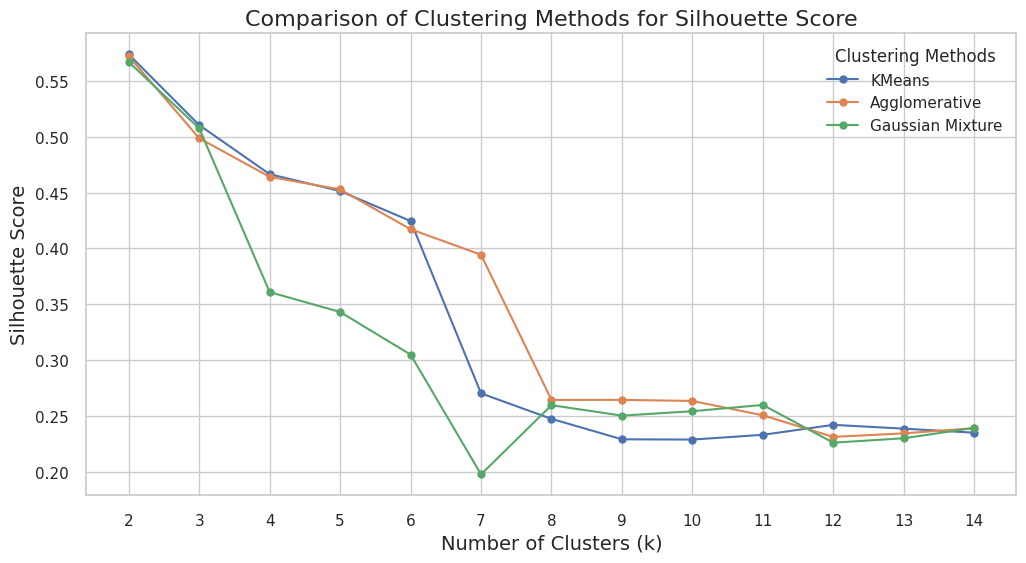

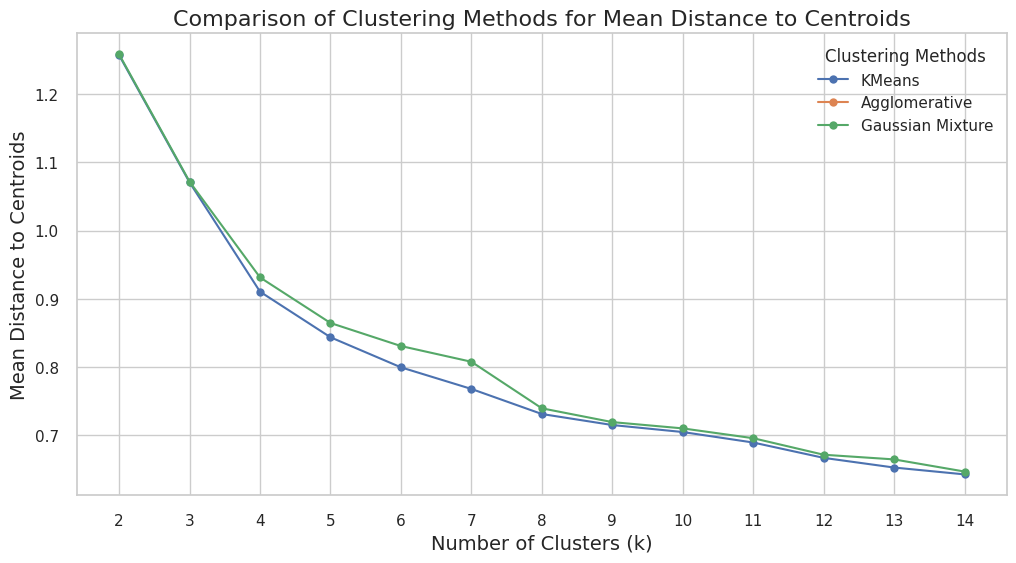

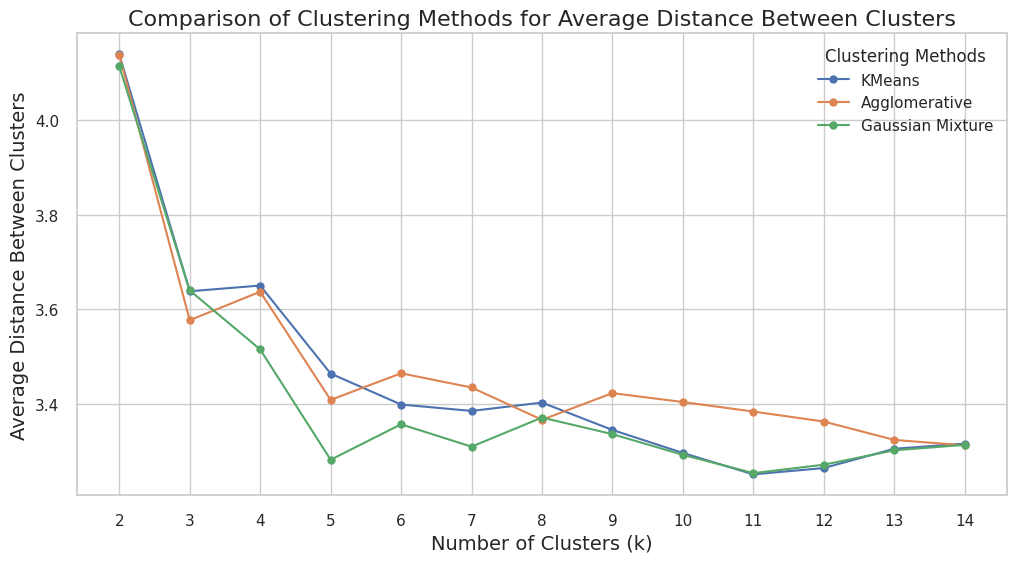

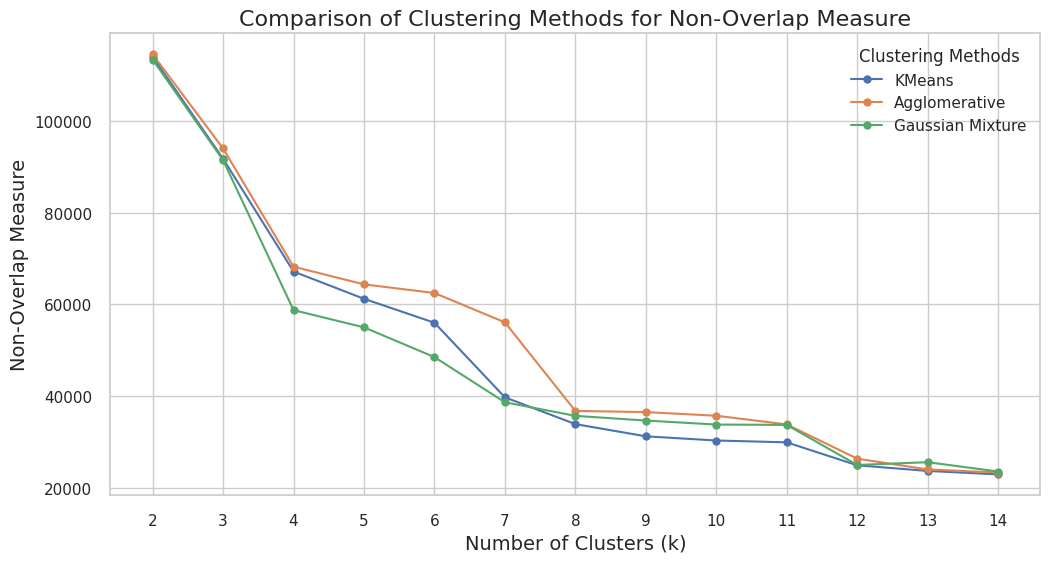

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para las gráficas
sns.set(style='whitegrid')

# Listar métricas a graficar
metrics = ['Silhouette Score', 'Mean Distance to Centroids', 'Average Distance Between Clusters', 'Non-Overlap Measure']

# Crear una gráfica para cada métrica
for metric in metrics:
    plt.figure(figsize=(12, 6))

    # Graficar cada método de clustering
    for method in methods.keys():
        # Filtrar los resultados por método
        method_results = results[results['Method'] == method]

        # Graficar la métrica correspondiente
        plt.plot(method_results['k'], method_results[metric], marker='o', label=method)

    # Configuraciones de la gráfica
    plt.title(f'Comparison of Clustering Methods for {metric}', fontsize=16)
    plt.xlabel('Number of Clusters (k)', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.xticks(range(2, 15))
    plt.legend(title='Clustering Methods')
    plt.grid(True)

    # Guardar la gráfica
    plt.savefig(f'clustering_{metric}.png')
    plt.show()
